# Introduction
<hr style="border:2px solid black"> </hr>

<div class="alert alert-block alert-warning">
<font color=black>

**What?** Multi-Step LSTM Models

</font>
</div>

# What is a multi-step time series analysis?

<div class="alert alert-block alert-info">
<font color=black><br>

- A **multi-step** time series forecasting problem requires a prediction of multiple time steps into the future.

- There are two main types of LSTM models that can be used for multi-step forecasting; they are:
    - Vector Output Model
    - Encoder-Decoder Model
  
<br></font>
</div>

# Import modules

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Flatten, TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D
import matplotlib.pyplot as plt
from matplotlib import rcParams
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# Helper functions

In [2]:
def plotLearningHistory(history):
    """Plot learning history.
    """
    
    epochs = len(history.history[ "loss"]) 
    x = range(0, epochs)

    rcParams['figure.figsize'] = 15, 5
    rcParams['font.size'] = 20

    fig, ax = plt.subplots()
    ax.plot(x, history.history[ "loss"], 'r-', lw = 3, label = 'Train') 

    ax.legend() 
    plt.xlabel('Epochs')
    plt.ylabel("MSE")
    plt.title('Training history')

    ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
    ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
    ax.tick_params(which = 'major', direction='in', length=10, width=2)
    ax.tick_params(which = 'minor', direction='in', length=6, width=2)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    plt.yscale('log')
    ax.minorticks_on()
    plt.show()

# Create dataset

<div class="alert alert-block alert-info">
<font color=black><br>

- Both the input and output components will be comprised of multiple time steps.
- These may or may not have the same number of steps.
- Remember that a multi-step time series forecasting problem requires a prediction of multiple time steps into the future.

<br></font>
</div>

In [3]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    
    """Split a univariate sequence into samples
    
    sequence = univariate series, meaning there is only
    one target we'd like to predict
    n_step_in = how many step back do you want to keep?
    n_step_out = howm any steps forwrd do you want to keep?
    """
    
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [4]:
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# summarize the data
for i in range(len(X)):
    print(X[i], y[i])

[10 20 30] [40 50]
[20 30 40] [50 60]
[30 40 50] [60 70]
[40 50 60] [70 80]
[50 60 70] [80 90]


# Vector output model

<div class="alert alert-block alert-info">
<font color=black><br>

- Like other types of neural network models, the LSTM can output a vector directly that can be interpreted as a multi-step forecast.
- This means we just need to take care of the input and output shapes.

<br></font>
</div>

In [5]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X.shape

(5, 3, 1)

## Stacked LSTM

In [6]:
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [7]:
# Fit model
history = model.fit(X, y, epochs = 300, verbose=0)

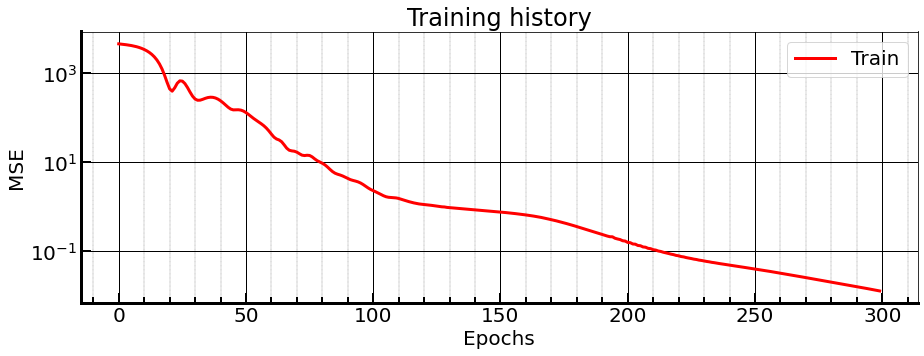

In [8]:
plotLearningHistory(history)

In [9]:
# Demonstrate prediction
x_input = np.array([70, 80, 90])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[101.63256  112.969955]]


In [10]:
# Demonstrate prediction
x_input = np.array([50, 60, 70])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[79.99128 89.9968 ]]


In [16]:
# Demonstrate prediction
x_input = np.array([30, 40, 50])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[59.900078 69.80403 ]]


# Encoder-Decoder Model

<div class="alert alert-block alert-info">
<font color=black><br>

- A model specifically developed for forecasting **variable length output** sequences is called the Encoder-Decoder LSTM.
- **Originally** the model was designed for prediction problems where there are both input and output sequences, so-called sequence-to-sequence, or seq2seq problems, such as translating text from one language to another.
- Nevertheless, this type of model can be used for multi-step time series forecasting.
- The **encoder** is a model responsible for reading and interpreting the input sequence. The output of the encoder is a fixed length vector that represents the model’s interpretation of the sequence. The encoder is traditionally a Vanilla LSTM model, although other encoder models can be used such as Stacked, Bidirectional, and CNN models.

<br></font>
</div>

In [11]:
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))

## Stacked LSTM

In [21]:
# define model
model1 = Sequential()
model1.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model1.add(RepeatVector(n_steps_out))
model1.add(LSTM(100, activation='relu', return_sequences=True))
model1.add(TimeDistributed(Dense(1)))
model1.compile(optimizer='adam', loss='mse')

In [22]:
# fit model
history1 = model1.fit(X, y, epochs = 1000, verbose = 1)

Epoch 1/1000
1/1 [==============================] - 3s 3s/step - loss: 4532.0967
Epoch 2/1000
1/1 [==============================] - 0s 6ms/step - loss: 4488.3970
Epoch 3/1000
1/1 [==============================] - 0s 7ms/step - loss: 4446.1118
Epoch 4/1000
1/1 [==============================] - 0s 7ms/step - loss: 4404.6782
Epoch 5/1000
1/1 [==============================] - 0s 7ms/step - loss: 4363.4126
Epoch 6/1000
1/1 [==============================] - 0s 7ms/step - loss: 4321.2788
Epoch 7/1000
1/1 [==============================] - 0s 9ms/step - loss: 4277.0059
Epoch 8/1000
1/1 [==============================] - 0s 8ms/step - loss: 4229.1479
Epoch 9/1000
1/1 [==============================] - 0s 9ms/step - loss: 4176.6431
Epoch 10/1000
1/1 [==============================] - 0s 7ms/step - loss: 4117.0176
Epoch 11/1000
1/1 [==============================] - 0s 7ms/step - loss: 4047.7817
Epoch 12/1000
1/1 [==============================] - 0s 7ms/step - loss: 3966.5481
Epoch 13/1000


1/1 [==============================] - 0s 7ms/step - loss: 0.4923
Epoch 203/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4891
Epoch 204/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4860
Epoch 205/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4829
Epoch 206/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4798
Epoch 207/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4768
Epoch 208/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.4737
Epoch 209/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4707
Epoch 210/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4676
Epoch 211/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.4646
Epoch 212/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4617
Epoch 213/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.4587
Epoch 214/1000
1/1 [=======================

1/1 [==============================] - 0s 7ms/step - loss: 0.0288
Epoch 404/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0285
Epoch 405/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0282
Epoch 406/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0280
Epoch 407/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.0277
Epoch 408/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0275
Epoch 409/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0273
Epoch 410/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 411/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0268
Epoch 412/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0266
Epoch 413/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0264
Epoch 414/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0262
Epoch 415/1000
1/1 [=======================

1/1 [==============================] - 0s 6ms/step - loss: 0.0122
Epoch 606/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.0122
Epoch 607/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0122
Epoch 608/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0121
Epoch 609/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0121
Epoch 610/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.0121
Epoch 611/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0121
Epoch 612/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0120
Epoch 613/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0120
Epoch 614/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0120
Epoch 615/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0119
Epoch 616/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0119
Epoch 617/1000
1/1 [=======================

1/1 [==============================] - 0s 5ms/step - loss: 0.0076
Epoch 808/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0075
Epoch 809/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.0075
Epoch 810/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0075
Epoch 811/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0075
Epoch 812/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0075
Epoch 813/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0075
Epoch 814/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0074
Epoch 815/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0074
Epoch 816/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0074
Epoch 817/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0074
Epoch 818/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0074
Epoch 819/1000
1/1 [=======================

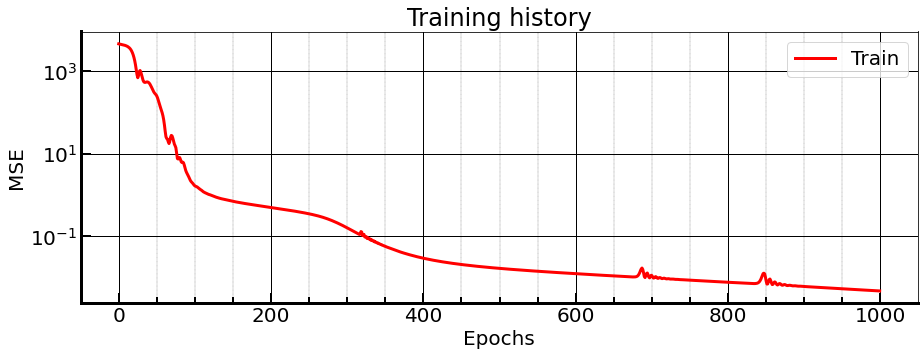

In [23]:
plotLearningHistory(history1)

In [24]:
# demonstrate prediction
x_input = np.array([70, 80, 90])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model1.predict(x_input, verbose=0)
print(yhat)

[[[101.94476 ]
  [111.284935]]]


In [25]:
# demonstrate prediction
x_input = np.array([90, 102.16514, 113.438354])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model1.predict(x_input, verbose=0)
print(yhat)

[[[125.757225]
  [135.0284  ]]]


In [26]:
# demonstrate prediction
x_input = np.array([160, 170, 180])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model1.predict(x_input, verbose=0)
print(yhat)

[[[208.37527]
  [219.36328]]]


In [27]:
# demonstrate prediction
x_input = np.array([300, 310, 320])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model1.predict(x_input, verbose=0)
print(yhat)

[[[377.222 ]
  [393.8382]]]


# References
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

- https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

</font>
</div>